# Image Translation
***
## Table of contents: <a class="anchor" id="toc"></a>

1. [Overview](#overview)   
2. [Setup](#setup)
3. [Explore input and target images](#explore)
4. [Metadata](#metadata)
5. [Pilot: 2D image translation on a small dataset](#pilot)
    * [Preprocessing](#preproc)
    * [Training](#train)
    * [Prediction](#predict)
    * [Model tuning](#tuning)
6. [Bonus: 2D image translation on a large dataset](#bonus)
***
This notebook illustrates image translation with deep convolutional neural networks (CNN). We frame the image translation as a regression problem solved using a residual U-Net model. The notebook demonstrates how to translate quantitative phase images of mouse kidney tissue to the fluorescence images of F-actin using data and model reported in our paper(https://doi.org/10.7554/eLife.55502).

## 1. Overview <a class="anchor" id="overview"></a>

U-Net model consists of an encoder (downsampling) part and a decoder (upsampling) part. The U-Net model is immensely popular for many image analysis tasks. One of the key design feature of the U-Net architecture is the skip connections between the encoder and decoder layers, which allows the model to learn patterns at multiple spatial resolutions. U-Nets were orginally designed for image segmentation (https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28). Using U-Nets for image translation (a regression problem) needs a few tweaks, such as: 
* changing the loss function, 
* changing the final activation layer, and 
* data normalization (more on that later).

Below is an overview of the 2D and 2.5D residual U-Net model architecture. The main differences from the original U-Net architecture are: 
1. we add short skip connection within each block (residual block) in addtion to the long skip connections in the original U-Net. 
2. The 2.5D model provides better translation accuracy than 2D model - it uses 3D stacks as input and predicts 2D output. 

![U-Net architecture](supp_modelarch_RGB.png)

The 2D model translates slice$\rightarrow$slice, whereas 2.5D model translates stack$\rightarrow$slice. 

We'll be using the architecture similar to above, but with same convolution instead of valid convolution.  Same convolution operation pads the input image so that the output image has the same size as the input image after convolution.

**BACK TO [TABLE OF CONTENTS](#toc)**

## 2. Setup: libraries and paths <a class="anchor" id="setup"></a>

Let's start with some imports. We'll be using the open source U-Net repository [microDL](https://github.com/czbiohub/microDL) , so we'll import that along with some plotting and other utility packages.


In [1]:
# autoreload modules before executing
%load_ext autoreload
%autoreload 2

import glob
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import importlib
import os
import pandas as pd
import pprint
import sys

# Add module path to sys
module_path = os.path.abspath(os.path.join('..'))
print("System path: "+module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
    
import micro_dl.utils.meta_utils as meta_utils
import micro_dl.cli.train_script as train
import micro_dl.cli.preprocess_script as preprocess
import micro_dl.utils.aux_utils as aux_utils
import micro_dl.utils.image_utils as im_utils
import micro_dl.utils.masks as mask_utils
import micro_dl.utils.normalize as norm_utils
import micro_dl.utils.train_utils as train_utils
import micro_dl.inference.image_inference as image_inf
import micro_dl.cli.metrics_script as metrics
    
# Setup pretty printing
pp = pprint.PrettyPrinter(indent=4)


font = {'family' : 'DejaVu Sans',
        'size'   : 20}

matplotlib.rc('font', **font)
%matplotlib inline

System path: /home/mehtas/04_image_translation/microDL


Using TensorFlow backend.
/home/mehtas/miniconda3/envs/microdlTF113/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mehtas/miniconda3/envs/microdlTF113/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mehtas/miniconda3/envs/microdlTF113/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])

Next, we define paths where input images are stored and where processed data and model will be saved.

In [2]:
# This is the directory where our imaging data is downloaded
INPUT_DIR = os.path.join(os.path.expanduser('~'), '04_image_translation/data')
# INPUT_DIR = '/mnt/efs/woods_hole/04_image_translation_data/kidneytissue'

# And specify where we want to store our preprocessed data
PREPROC_OUTPUT_DIR = os.path.join(os.path.expanduser('~'), '04_image_translation/data/tiles_small')
# PREPROC_OUTPUT_DIR = os.path.join(os.path.expanduser('~'), '04_image_translation_data/tmp/tile_small')

# This is where the model weights and related variables will be stored
MODEL_DIR = os.path.join(os.path.expanduser('~'), '04_image_translation/data/translation_model')

**BACK TO [TABLE OF CONTENTS](#toc)**

## 3. Explore input and target images <a class="anchor" id="explore"></a>

The goal of this exercise is to translate 2D slices of phase or retardance image into 2D slices of fluorescene images of F-actin and DNA. Let's start by looking at some example images.

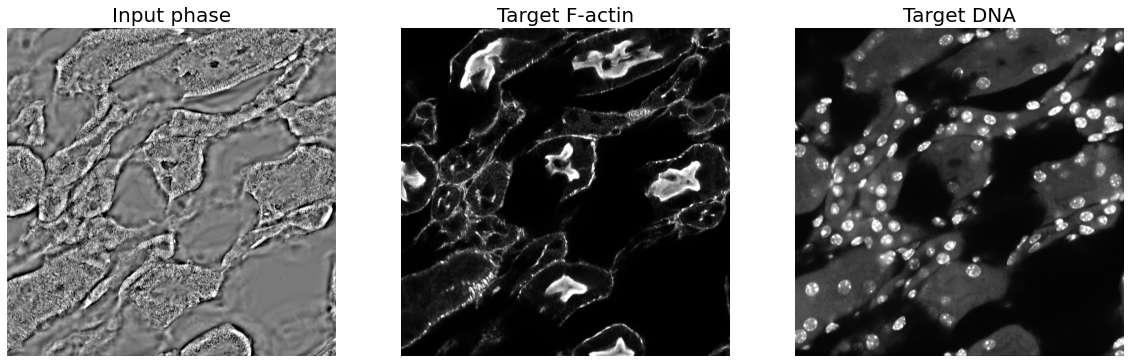

In [3]:
# import the libaries again if the plots don't display properly
actin_path = os.path.join(INPUT_DIR, 'img_568_t000_p003_z010.tif') #F-actin was imaged with Alexa Fluor 568 using 468nm excitation wavelength.
dna_path=os.path.join(INPUT_DIR, 'img_405_t000_p003_z010.tif') # DNA was imaged with Hoechst using 405nm excitation wavelength.
input_path=os.path.join(INPUT_DIR,'img_phase_t000_p003_z010.tif') # the phase and polarization were imaged using 530nm wavelength.

actin = im_utils.read_image(actin_path)
# This will clip the top and bottom 1% of intensitites
actin = norm_utils.hist_clipping(actin, 1, 99)
dna = im_utils.read_image(dna_path)
dna = norm_utils.hist_clipping(dna, 1, 99)
im_input = im_utils.read_image(input_path) 
im_input = norm_utils.hist_clipping(im_input, 0.8, 99.5) 
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(20, 15)
ax = ax.flatten()
ax[0].imshow(im_input, cmap='gray')
ax[0].set_title('Input phase',fontsize=20)
ax[1].imshow(actin, cmap='gray')
ax[1].set_title('Target F-actin',fontsize=20)
ax[2].imshow(dna, cmap='gray')
ax[2].set_title('Target DNA',fontsize=20)
for a in ax: a.axis('off')

plt.show()
plt.close('all')

**BACK TO [TABLE OF CONTENTS](#toc)**

## 4. Metadata <a class="anchor" id="metadata"></a>

microDL uses CSV file to track the metadata of the images. We'll generate the metadata and take a look:

In [4]:
meta_utils.frames_meta_generator(INPUT_DIR)
meta_utils.ints_meta_generator(INPUT_DIR,
                               num_workers=8,
                               )
frames_meta = pd.read_csv(os.path.join(INPUT_DIR, 'frames_meta.csv'), index_col=0)
frames_meta

,channel_idx,pos_idx,slice_idx,time_idx,channel_name,dir_name,file_name
0,0,3,10,0,405,/home/mehtas/04_image_translation/data,img_405_t000_p003_z010.tif
1,0,3,11,0,405,/home/mehtas/04_image_translation/data,img_405_t000_p003_z011.tif
2,0,3,12,0,405,/home/mehtas/04_image_translation/data,img_405_t000_p003_z012.tif
3,0,3,13,0,405,/home/mehtas/04_image_translation/data,img_405_t000_p003_z013.tif
4,0,3,14,0,405,/home/mehtas/04_image_translation/data,img_405_t000_p003_z014.tif
...,...,...,...,...,...,...,...
715,3,99,11,0,phase,/home/mehtas/04_image_translation/data,img_phase_t000_p099_z011.tif
716,3,99,12,0,phase,/home/mehtas/04_image_translation/data,img_phase_t000_p099_z012.tif
717,3,99,13,0,phase,/home/mehtas/04_image_translation/data,img_phase_t000_p099_z013.tif
718,3,99,14,0,phase,/home/mehtas/04_image_translation/data,img_phase_t000_p099_z014.tif


Each channel in our data is assgined with a unique channel ID. We'll reference the channels by their IDs in the config files. Let's check the channel IDs 

In [5]:
chan_id_df = frames_meta[['channel_idx', 'channel_name']].drop_duplicates()
chan_id_df

,channel_idx,channel_name
0,0,405
180,1,568
360,2,Retardance
540,3,phase


**BACK TO [TABLE OF CONTENTS](#toc)**

## 5. Pilot: 2D image translation (slice$\rightarrow$slice) on small dataset <a class="anchor" id="pilot"></a>

### Preprocessing <a class="anchor" id="preproc"></a>

We will  be using three main modules of microDL for image translation: preprocessing, training and inference (see imports above).

The first step is the preprocessing. We have some options like resizing, flatfield correction, creating masks, and tiling. The data we're working with is already background corrected so we can safely skip that part. We also don't need to resize the images.

We would however like to create masks based on our target data. The reason for that is that we would like to avoid training on background only, that is empty or near empty tiles. A threshold we found reasonable is to make sure that our tiles contain 25% signal or more.

We would also like to tile our images. The original image size (2048 x 2048 pixels) is too large to be able to fit into memory and similar structures reappear across the images. So we'd be much better off splitting the images into smalle pieces (tiles). A design consideration for convolution neural networks is the [receptive field](https://medium.com/mlreview/a-guide-to-receptive-field-arithmetic-for-convolutional-neural-networks-e0f514068807), which is the region of the input space a given feature is looking at. Given the size of our structures of interest and our network architecture, we use 256 x 256 pixel tiles. Also, training on smaller tiles allow us to use bigger batch size so the training converges faster.

#### A. Masks

We would like to generate binary masks based on our target channel. Let's for now assume our target channel is channel index = 2. In microDL we have two types of global binary thresholding methods builtin, [Otsu](https://en.wikipedia.org/wiki/Otsu%27s_method) and [unimodal](https://users.cs.cf.ac.uk/Paul.Rosin/resources/papers/unimodal2.pdf) (or Rosin) thresholding.
Let's load an image, generate masks and plot them side by side.

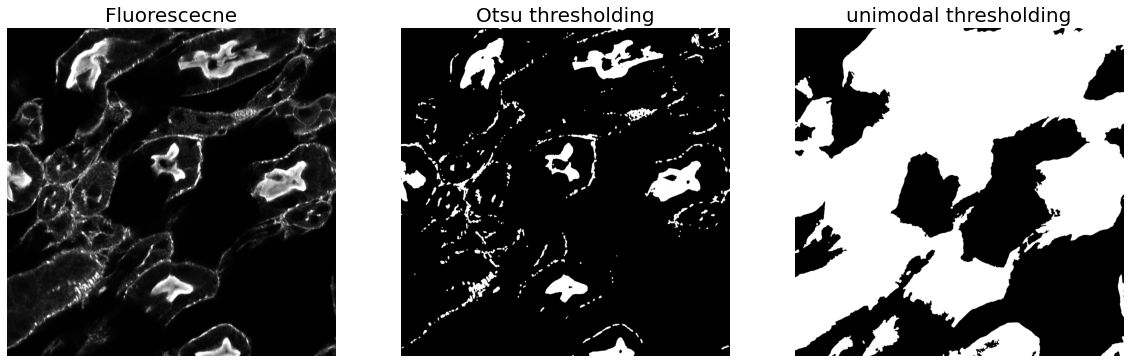

In [6]:
# Load image
im_path = os.path.join(INPUT_DIR, 'img_568_t000_p003_z010.tif')
im = im_utils.read_image(im_path)
# Clip top and bottom 1% of histogram for better visualization
im = norm_utils.hist_clipping(im, 1, 99)

mask_otsu = mask_utils.create_otsu_mask(im)
mask_rosin = mask_utils.create_unimodal_mask(im)

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(20, 15)
ax = ax.flatten()
ax[0].imshow(im, cmap='gray')
ax[0].set_title('Fluorescecne',fontsize=20)
ax[1].imshow(mask_otsu, cmap='gray')
ax[1].set_title('Otsu thresholding',fontsize=20)
ax[2].imshow(mask_rosin, cmap='gray')
ax[2].set_title('unimodal thresholding',fontsize=20)
for a in ax: a.axis('off')

plt.show()
plt.close('all')

As you can see, the Otsu threshold captures only the very bright structures and misses dim structures. Rosin thresholding does a better job at these dim structures, so we'll be using Rosin thresholding for the analysis.

#### B. configuration

Usually we run microDL through command line interfaces (CLIs), which is to say we just input commands in the terminal. For each module we specify the path to a config file as a command line argument. Since we're using Jupyter Notebook for this tutorial we will instead load the preprocessing config so we can take a look at it.

In [7]:
config_path = os.path.join(
    module_path,
    'micro_dl/config_preprocess.yml',
)
preproc_config = aux_utils.read_config(config_path)
pp.pprint(preproc_config)

{   'channel_ids': [0, 1, 2, 3],
    'flat_field': {'flat_field_channels': [0, 1], 'method': 'estimate'},
    'input_dir': '/gpfs/CompMicro/projects/virtualstaining/kidneyslice/2019_02_15_kidney_slice/MBL_DL_image_translation/data',
    'make_weight_map': False,
    'masks': {   'channels': [1],
                 'mask_ext': '.png',
                 'mask_type': 'unimodal',
                 'str_elem_radius': 3},
    'metadata': {'name_parser': 'parse_sms_name', 'order': 'cztp'},
    'normalize': {   'min_fraction': 0.25,
                     'normalize_channels': [True, True, True, True],
                     'normalize_im': 'dataset'},
    'num_workers': 12,
    'output_dir': '/gpfs/CompMicro/projects/virtualstaining/kidneyslice/2019_02_15_kidney_slice/MBL_DL_image_translation/temp/tile_small',
    'pos_ids': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'slice_ids': [10, 11, 12, 13, 14, 15],
    'tile': {   'depths': [1, 1, 1, 1],
                'image_format': 'zyx',
                'min_

There are some things we need to change around here:

In [8]:
# We're not doing resizing so let's remove that key
if 'resize' in preproc_config:
    preproc_config.pop('resize')
# We're not doing flatfield correction either
if 'flat_field' in preproc_config:
    preproc_config.pop('flat_field')
    
# We need to change input_dir to point to where our image data is located
preproc_config['input_dir'] = INPUT_DIR

# And where we want to store our preprocessed data
preproc_config['output_dir'] = PREPROC_OUTPUT_DIR

# Set which channels we want to preprocess and if they should be normalized
preproc_config['channel_ids'] = [0, 1, 2, 3]
preproc_config['normalize']['normalize_channels'] = [True, True, True, True]

# Set the channels used for generating masks
preproc_config['masks']['channels'] = 1

# Switch to unimodal (Rosin) thresholding
preproc_config['masks']['mask_type'] = 'unimodal'

# Set the number of workers to the number of available cores
preproc_config['num_workers'] = 8

# Let's look again
pp.pprint(preproc_config)

{   'channel_ids': [0, 1, 2, 3],
    'input_dir': '/home/mehtas/04_image_translation/data',
    'make_weight_map': False,
    'masks': {   'channels': 1,
                 'mask_ext': '.png',
                 'mask_type': 'unimodal',
                 'str_elem_radius': 3},
    'metadata': {'name_parser': 'parse_sms_name', 'order': 'cztp'},
    'normalize': {   'min_fraction': 0.25,
                     'normalize_channels': [True, True, True, True],
                     'normalize_im': 'dataset'},
    'num_workers': 8,
    'output_dir': '/home/mehtas/04_image_translation/data/tiles_small',
    'pos_ids': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'slice_ids': [10, 11, 12, 13, 14, 15],
    'tile': {   'depths': [1, 1, 1, 1],
                'image_format': 'zyx',
                'min_fraction': 0.25,
                'step_size': [128, 128],
                'tile_size': [256, 256]},
    'uniform_struct': True,
    'verbose': 10}


#### C. Preprocess data
Now it's time to run the preprocessing: the runtime should be aroud 5 minute. 
If this step is taking too long. You can use the previously processed data by setting:

`INPUT_DIR = '/mnt/efs/woods_hole/04_image_translation_data/kidneytissue'`

`PREPROC_OUTPUT_DIR = os.path.join(os.path.expanduser('~'), '04_image_translation_data/tmp/tile_small')`

If you get an error about "Don't specify a mask_dir", try reloading the config by running the last two blocks.

In [9]:
preproc_config, runtime = preprocess.pre_process(preproc_config)
print("Preprocessing took {} seconds".format(runtime))
# Save the final config and run time
preprocess.save_config(preproc_config, runtime)

tile image t000 p003 z014 c004...tile image t000 p003 z015 c004...
tile image t000 p004 z010 c004...tile image t000 p004 z011 c004...


tile image t000 p003 z010 c004...tile image t000 p003 z011 c004...
tile image t000 p003 z012 c004...

tile image t000 p003 z013 c004...
tile image t000 p004 z012 c004...
tile image t000 p004 z013 c004...tile image t000 p004 z014 c004...

tile image t000 p004 z015 c004...
tile image t000 p005 z010 c004...
tile image t000 p005 z011 c004...
tile image t000 p005 z012 c004...
tile image t000 p005 z013 c004...
tile image t000 p005 z014 c004...tile image t000 p005 z015 c004...
tile image t000 p006 z010 c004...

tile image t000 p006 z011 c004...
tile image t000 p006 z012 c004...
tile image t000 p006 z013 c004...
tile image t000 p006 z014 c004...
tile image t000 p006 z015 c004...
tile image t000 p007 z010 c004...tile image t000 p007 z011 c004...

tile image t000 p007 z013 c004...tile image t000 p007 z012 c004...

tile image t000 p007 z014 c004...
tile image t00

You can navigate to your output_dir and take a look at what was generated. You will find a mask_dir containing masks, a tile_dir containing tiles and JSON file containing the all the information that was used to generated the preprocessed data. Let's take a look at a few tiles. Change `tile_dir` to `os.path.join(os.path.expanduser('~'), '04_image_translation_data/tmp/tile_small/tiles_256-256_step_128-128' )` if preprocessing didn't finish properly.

/home/mehtas/04_image_translation/data/tiles_small/tiles_256-256_step_128-128
im_c001_z011_t000_p006_r896-1152_c256-512_sl0-1.npy im shape (1, 256, 256)
im_c002_z012_t000_p010_r896-1152_c256-512_sl0-1.npy im shape (1, 256, 256)
im_c001_z010_t000_p010_r1024-1280_c768-1024_sl0-1.npy im shape (1, 256, 256)
im_c002_z015_t000_p007_r1280-1536_c1664-1920_sl0-1.npy im shape (1, 256, 256)
im_c004_z010_t000_p003_r896-1152_c896-1152_sl0-1.npy im shape (1, 256, 256)
im_c002_z014_t000_p010_r128-384_c256-512_sl0-1.npy im shape (1, 256, 256)
im_c000_z012_t000_p004_r1408-1664_c1408-1664_sl0-1.npy im shape (1, 256, 256)
im_c003_z014_t000_p004_r1280-1536_c384-640_sl0-1.npy im shape (1, 256, 256)
im_c000_z015_t000_p005_r1024-1280_c1024-1280_sl0-1.npy im shape (1, 256, 256)
im_c004_z015_t000_p006_r256-512_c1792-2048_sl0-1.npy im shape (1, 256, 256)
im_c003_z015_t000_p010_r1024-1280_c768-1024_sl0-1.npy im shape (1, 256, 256)
im_c003_z012_t000_p011_r512-768_c1152-1408_sl0-1.npy im shape (1, 256, 256)
im_c00

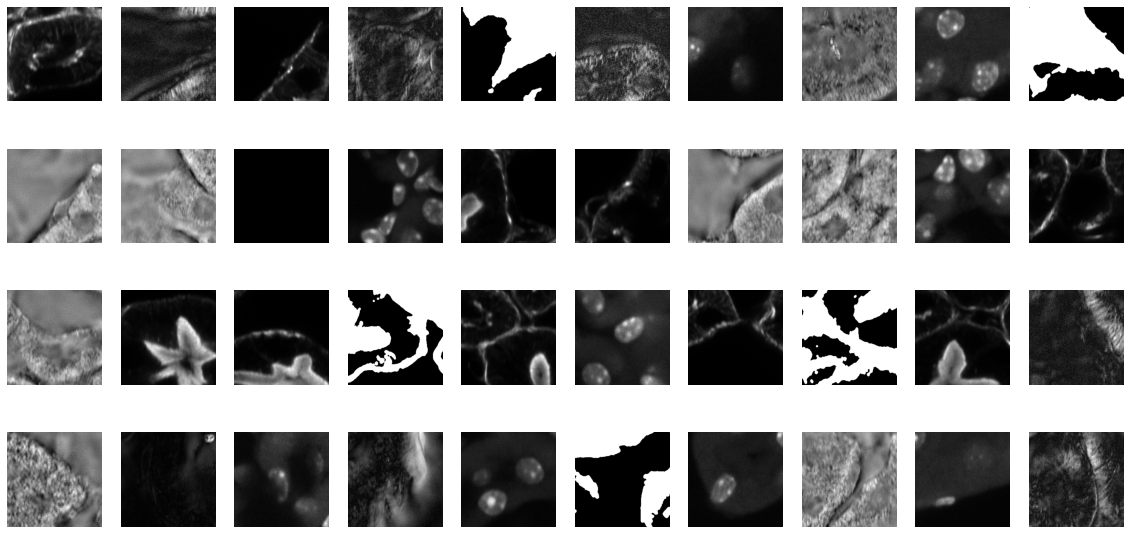

In [10]:
tile_dir = preproc_config['tile']['tile_dir']
# tile_dir =os.path.join(os.path.expanduser('~'), '04_image_translation_data/tmp/tile_small/tiles_256-256_step_128-128' )
print(tile_dir)
frames_meta = pd.read_csv(os.path.join(tile_dir, 'frames_meta.csv'))
# Randomly select 40 tiles and plot them
subset = np.random.choice(frames_meta.shape[0], 40, replace=False)
fig, ax = plt.subplots(4, 10)
fig.set_size_inches(20, 10)
ax = ax.flatten()
for i, axi in enumerate(ax):
    im = im_utils.read_image(os.path.join(tile_dir, frames_meta.loc[subset[i], 'file_name']))
    print(frames_meta.loc[subset[i], 'file_name'], 'im shape', im.shape)
    axi.imshow(np.squeeze(im), cmap='gray'); axi.axis('off')
plt.show()
plt.close('all')

**BACK TO [TABLE OF CONTENTS](#toc)**

### Training  <a class="anchor" id="train"></a>
Now that we've preprocessed our data we're ready to train. During this exercise, we will use phase or retardance image to predict two different fluorescent channels, actin and nuclei.
In our dataset, the channel names and indices are the following:

* Retardance: channel name Retardance, index 2
* Phase: channel name phase, index 3
* Actin:channel name 568, index 1
* Nuclei: channel name 405, index 0

#### A. configuration

We specify the network architecture and training parameters using another config file. Let's load a base 2D training config file and take a look.

In [3]:
config_path = os.path.join(
    module_path,
    'micro_dl/config_train.yml',
)
train_config = aux_utils.read_config(config_path)
pp.pprint(train_config)

{   'dataset': {   'augmentation': True,
                   'data_dir': '/gpfs/CompMicro/projects/virtualstaining/kidneyslice/2019_02_15_kidney_slice/MBL_DL_image_translation/temp/tile_small/tiles_256-256_step_128-128',
                   'input_channels': [3],
                   'mask_channels': [4],
                   'model_task': 'regression',
                   'normalize': False,
                   'random_seed': 42,
                   'split_by_column': 'pos_idx',
                   'split_ratio': {'test': 0.15, 'train': 0.7, 'val': 0.15},
                   'target_channels': [0],
                   'train_fraction': 1},
    'network': {   'activation': {'type': 'relu'},
                   'batch_norm': True,
                   'block_sequence': 'conv-activation-bn',
                   'class': 'UNet2D',
                   'data_format': 'channels_first',
                   'depth': 1,
                   'dropout': 0.2,
                   'filter_size': 3,
                   'f

There are a lot more options here, as you can see. The first things to check for when doing image translation is that the final activation is linear. Unlike for binary segmentation when we want to use a sigmoid to move values towards either zero or one, we would here like to do a regression and not apply any transform to our output signal.

There are some variables that it would be interesting for you to explore while training:

##### Loss
The second thing is to choose a loss function that makes sense. Common choices for regression are the mean squared error (MSE) and the mean absolute error (MAE) between the target image y and the estimated image y':
\begin{equation*}
MSE = \sum_{p} (y_p - y_p')^2,
\end{equation*}

\begin{equation*}
MAE = \sum_{p} |y_p - y_p'|
\end{equation*}
for each pixel index p.

You can try both by changing train_config['trainer']['loss']. The names in microDL for losses are mse_loss and mae_loss, respectively. You can also try other custom losses by using the loss function names [here](https://github.com/czbiohub/microDL/blob/master/micro_dl/train/losses.py), or any standard [Keras loss function](https://keras.io/losses/) by specifying the loss function name defined by Keras. 

##### Optimizer
A good default choice of optimizer is Adam. You can read more about different deep learning optimizers [here](http://ruder.io/optimizing-gradient-descent/), and you can change the optimizer you'd like to use in your training by changing the variable train_config['trainer']['optimizer']['name'] to any of the Keras optimizers listed [here](https://keras.io/optimizers/).

##### Learning Rate
If the learning rate is too small your training might take a very long time to converge, and if it's too big it might not converge at all. It's worth trying some different values and see what happens with convergence.

##### Dropout
Since we're working with a very small dataset in exploratory training, chances are that your network will overfit to your training data. It's worth exploring train_config['network']['dropout'] and to see if increasing those variables can reduce overfitting.

##### Number of filters
The number of filters in each layer of the model controls the model capacity. This parameter is train_config['network']['num_filters_per_block']. Too large model capacity can lead to overfitting and not necesssarily better results.

##### Augmentation
The data is flipped and rotated randomly to diversify the training set and mitigate overfitting.

##### Other?
If you have extra time or are curious about the other variables, feel free to explore.

For our training config, we need to make some adjustments:

In [4]:
# Set the data directory to the directory we generated during preprocessing
train_config['dataset']['data_dir'] = os.path.join(PREPROC_OUTPUT_DIR, 'tiles_256-256_step_128-128')

# We also need to specify where we want to store our model and all related data generated by training
# This directory will be created if it doesn't already exist
train_config['trainer']['model_dir'] = MODEL_DIR

# Set maximum number of epochs to 6 so we can explore difference parameters quickly
train_config['trainer']['max_epochs'] = 10
train_config['trainer']['batch_size'] = 64
# Predict actin (channel 1) from phase (channel 3)
train_config['dataset']['input_channels'] = [3]
train_config['dataset']['target_channels'] = [1]

# Enable data augmentation.
train_config['dataset']['augmentation'] = True
# Use all training data each epoch
if 'train_fraction' in train_config['dataset']:
    train_config['dataset'].pop('train_fraction')
# Set number of filters
train_config['network']['num_filters_per_block'] = [16, 32, 48, 64, 80]
# Select L1 loss
train_config['trainer']['loss'] = 'mae_loss'

#### B. Time to train. 

In [5]:
# First, specify the gpu that you want to run training on, or "None" to select the gpu with most memory available
gpu_id = 0
gpu_id, gpu_mem_frac = train_utils.select_gpu(gpu_ids=gpu_id)

Using GPU 0 with memory fraction 0.970703125.


Try restarting the notebook kernel if the gpu memory is occupied and you run into errors about "can't creat training session".
Training 6 epochs should take no more than 5 minutes if you're on a GPU.

In [6]:
train.run_action(
    action='train',
    config=train_config,
    gpu_ids=gpu_id,
    gpu_mem_frac=gpu_mem_frac,
)

1.13.1
2.1.6
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model compiled
Steps per epoch: 130


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 256, 256)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 256, 256) 160         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 16, 256, 256) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 256, 256) 64          activation_1[0][0]               
__________________________________________________________________________________________________
dropout_1 

Training time: 1505.1978619098663



Epoch 00010: val_loss did not improve from 0.60335


We've completed our first training. Let's take a look at what happened during training by opening a history log file.

In [7]:
history = pd.read_csv(os.path.join(MODEL_DIR, 'history.csv'))
history

,epoch,coeff_determination,loss,val_coeff_determination,val_loss
0,0,-0.151859,1.122106,-1.349918,2.017090
1,1,0.256863,0.804421,-0.189103,1.023080
2,2,0.348487,0.737054,0.106051,0.779811
3,3,0.399360,0.701471,0.063688,0.778994
4,4,0.441670,0.672394,0.380558,0.644592
5,5,0.486388,0.645466,0.442344,0.635044
6,6,0.511851,0.628354,0.465794,0.603352
7,7,0.539134,0.610675,0.474726,0.607408
8,8,0.551667,0.599540,0.411925,0.633081
9,9,0.569349,0.589973,0.335547,0.651714


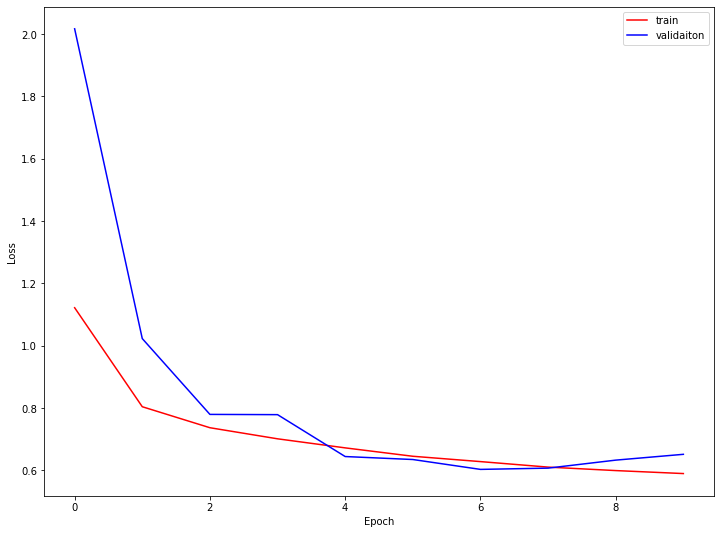

In [8]:
# Plot training vs. validation loss
fig, ax = plt.subplots()
fig.set_size_inches(12, 9)
ax.plot(history['epoch'], history['loss'], 'r')
ax.plot(history['epoch'], history['val_loss'], 'b')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.legend(['train', 'validaiton'])
plt.show()

##### **Does it look like the model is overfitting? How can you tell?**


**BACK TO [TABLE OF CONTENTS](#toc)**

### Predictions on test set <a class="anchor" id="predict"></a>

We'd also like to see how well the model performs predictions. For that we will have to run inference on our test dataset. We will run model inference on the full size 2048 X 2048 image instead of on tiles in training. Why can we run the model inference on different input size? And what are the benefits of doing that?   

#### A. configuration

In [ ]:
config_path = os.path.join(
    module_path,
    'micro_dl/config_inference.yml',
)
inf_config = aux_utils.read_config(config_path)
pp.pprint(inf_config)

In [ ]:
inf_config['image_dir'] = INPUT_DIR 
inf_config['preprocess_dir'] = PREPROC_OUTPUT_DIR
inf_config['model_dir'] = MODEL_DIR
inf_config['dataset']['input_channels'] = [3]
inf_config['dataset']['target_channels'] = [1]
inf_config['metrics']['metrics_orientations'] = ['xy']

#### B. Run prediction

In [ ]:
inference_inst = image_inf.ImagePredictor(
                train_config=train_config,
                inference_config=inf_config,
                preprocess_config=preproc_config,
                gpu_id=gpu_id,
                gpu_mem_frac=gpu_mem_frac,
            )
inference_inst.run_prediction()

There should be a new subdirectory created in the model directory with the predictions and the metrics. Use glob to see what files were generated during inference.

In [ ]:
pred_dir = os.path.join(MODEL_DIR, 'predictions')
glob.glob(os.path.join(pred_dir, '*'))

Plot an example of input, target and prediction side by side.

In [ ]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(20, 15)
ax = ax.flatten()
for a in ax: a.axis('off')

im_path = os.path.join(INPUT_DIR, 'img_phase_t000_p011_z013.tif')
im = im_utils.read_image(im_path)
im = norm_utils.hist_clipping(im, 1, 99)
ax[0].imshow(im, cmap='gray'); ax[0].set_title('Input: Phase', fontsize=20)
im_path = os.path.join(INPUT_DIR, 'img_568_t000_p011_z013.tif')
im = im_utils.read_image(im_path)
im = norm_utils.hist_clipping(im, 1, 99)
ax[1].imshow(im, cmap='gray'); ax[1].set_title('Target 1: Actin', fontsize=20)
im_path = os.path.join(pred_dir, 'img_pred_t000_p011_z013.tif')
im = im_utils.read_image(im_path)
im = norm_utils.hist_clipping(im, 1, 99)
ax[2].imshow(im, cmap='gray'); ax[2].set_title('Prediction of Actin', fontsize=20)
plt.show()
plt.close('all')

The prediction is much blurrier than the target. One reason you can't exactly mimic the F-actin target, because the input channel carries only part of the information about the structure and the random noise cannot be learned.

Another reason for blurry prediction is that loss functions like MSE or MAE tend to generate blurrier prediction because these loss functions generate an "average" prediction when there are multiple possible predictions.  

Also, we've here used a very limited amount of data. To get higher correlation we will need to include much more data and run training overnight.

Speaking of correlation, let's open the inference meta file and inspect the metrics comparing predictions and targets.

In [ ]:
metrics_meta = pd.read_csv(os.path.join(pred_dir, 'metrics_xy.csv'))
metrics_meta.head()

Get the median correlation of all rows in the inference csv file.

In [ ]:
print("Median Pearson correlation: {:.2f}".format(metrics_meta['corr'].median()))

**BACK TO [TABLE OF CONTENTS](#toc)**

### Model tuning <a class="anchor" id="tuning"></a>

Now it's time for you to experiment. You can try modeling a different channel (use retardance channel to predict F-actin) or play around with different settings in the train_config and rerun the training. What do you think will help improve the model?

**BACK TO [TABLE OF CONTENTS](#toc)**

##  Bonus: Training on larger dataset (slice$\rightarrow$slice)<a class="anchor" id="bonus"></a>

Hopefully above exploration has led you to set of parameters to predict F-actin and nuclei with decent accuracy. You  can now set up a model to train on larger dataset (30 FOVs) and evaluate if model accuracy improves as a result when you comeback. 

We will need change the position ids in the pre-process config to have 30 FOVs and re-run preprocessing. The position ids of 30 FOVs are:

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]

You can pick training/model parameters based on your parameter exploration from Session 1. A few tips for picking training parameters for overnight training:
- **Make sure you write preprocessed data and model trained on this large set to new folders.**
- Increase maximum number of epochs and early stopping patience to at least 200 and 10 so the training will run longer
- Increase the number of filters in the model to increase the model capacity. You might need to use smaller batch size so the model can fit into the GPU memory You might want to add some dropout as well to avoid overfitting if you increase the number of filters 
- Use lower learning rate. We used higher learning rate to make training converge faster
- Compare the mean and standard deviation of test metrics.



**BACK TO [TABLE OF CONTENTS](#toc)**